## Data Exploration

In [81]:

s3_bucket_path="s3://aegovan-data/human_output/human_keyinteractions.json"


In [82]:
import boto3

def download_single_file(bucket_name_path, local_path):
    index = bucket_name_path.find("://")

    # remove the s3:// if present
    if index > -1:
        bucket_name_path = bucket_name_path[index + 3:]

    key_start_index = bucket_name_path.find("/")
    bucket_name = bucket_name_path
    key = "/"
    if key_start_index > -1:
        bucket_name = bucket_name_path[0:key_start_index]
        key = bucket_name_path[key_start_index + 1:]
        
    client = boto3.resource('s3')
    client.Bucket(bucket_name).download_file(key, local_path)


In [83]:
data_file="input_data.json"
download_single_file(s3_bucket_path, data_file)

In [92]:

import pandas as pd

data = pd.read_json(data_file)

print("Total number of records: {}".format(data.shape[0]))

Total number of records 3381


### Sneak preview of the data

In [271]:
#TODO: Fix data format
data["pubmedId"] = data["pubmedId"].astype(str)

In [272]:
data.head(n=3)

,interactionId,interactionType,isNegative,participants,pubmedId,pubmedTitle,pubmedabstract,hasTriggerWord,entityMentionsCount
0,2503510,phosphorylation,false,"[{'uniprotid': 'P43405', 'alias': [['ksyk_huma...",25605870,None,NLRP3 is the most crucial member of the NLR fa...,True,0
1,2503513,phosphorylation,false,"[{'uniprotid': 'P43405', 'alias': [['ksyk_huma...",25605870,None,NLRP3 is the most crucial member of the NLR fa...,True,1
10,1796163,phosphorylation,false,"[{'uniprotid': 'Q8WUB1', 'alias': [['kc1g2_hum...",25500533,None,"LRRK2, a gene relevant to Parkinson's disease,...",True,1


### Number of interactions per paper
**Note: The number of interactions per paper only takes the filtered interactions extracted from the Intact database**

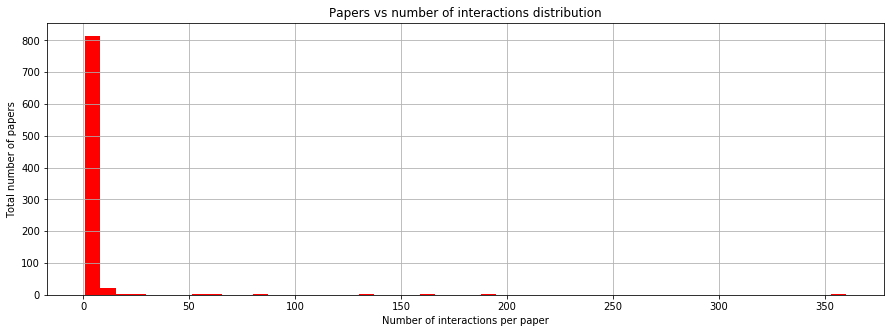

In [207]:
data.pubmedId.value_counts().hist (bins=50, figsize=(15,5), color = 'red')
plt.title('Papers vs number of interactions distribution')
plt.xlabel('Number of interactions per paper')
plt.ylabel('Total number of papers')

plt.show()

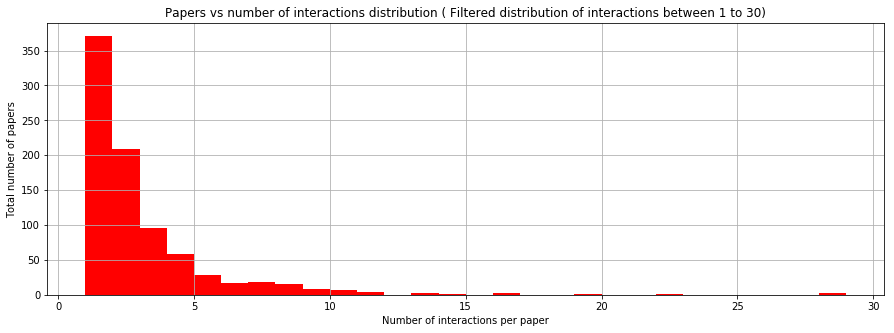

In [254]:
df = data.pubmedId.value_counts().hist (bins=range(1, 30), figsize=(15,5), color = 'red')

plt.title('Papers vs number of interactions distribution ( Filtered distribution of interactions between 1 to 30)')
plt.xlabel('Number of interactions per paper')
plt.ylabel('Total number of papers')

plt.show()

### Filter out interactions from paper with more than 15 interactions

In [278]:
pubmed_interaction_count = data.pubmedId.value_counts().to_frame().rename(columns={"pubmedId":"interactionCountPerPubmed"})


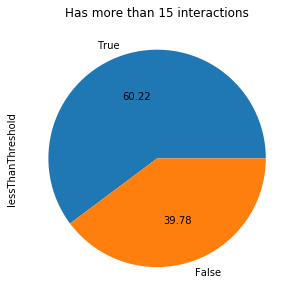

In [308]:
interactions_count= pd.DataFrame()
data["lessThanThreshold"] = data.apply(lambda r: r["pubmedId"] in  pubmed_interaction_count.query('interactionCountPerPubmed <= 15').index , 1)


data.lessThanThreshold.value_counts().plot.pie(autopct='%.2f',figsize=(5, 5))
plt.title('Has more than 15 interactions')
plt.show()

In [310]:
data = data.query("lessThanThreshold == 1")

In [337]:
print("Total number of records after filter: {}".format(data.shape[0]))

Total number of records after filter: 2036


### Interaction Types distribution

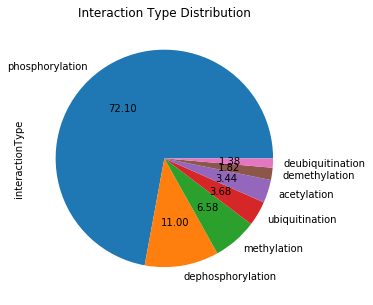

In [315]:
data.interactionType.value_counts().plot.pie(autopct='%.2f',figsize=(5, 5))
plt.title('Interaction Type Distribution')
plt.show()

In [316]:
data.interactionType.value_counts().to_frame()

,interactionType
phosphorylation,1468
dephosphorylation,224
methylation,134
ubiquitination,75
acetylation,70
demethylation,37
deubiquitination,28


### Number of participants per interaction

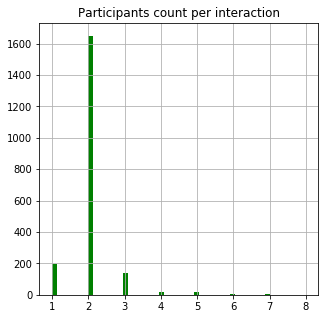

In [317]:
data["participants"].apply(lambda x: len(x)).hist (bins=50, figsize=(5,5), color = 'green')
plt.title("Participants count per interaction")
plt.show()

### Explore if the abstract contains the trigger word

In [318]:
data["hasTriggerWord"] = data.apply(lambda r: r["interactionType"] in r["pubmedabstract"] , 1)

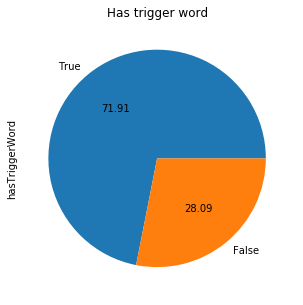

In [319]:
data.hasTriggerWord.value_counts().plot.pie(autopct='%.2f',figsize=(5, 5))
plt.title('Has trigger word')
plt.show()

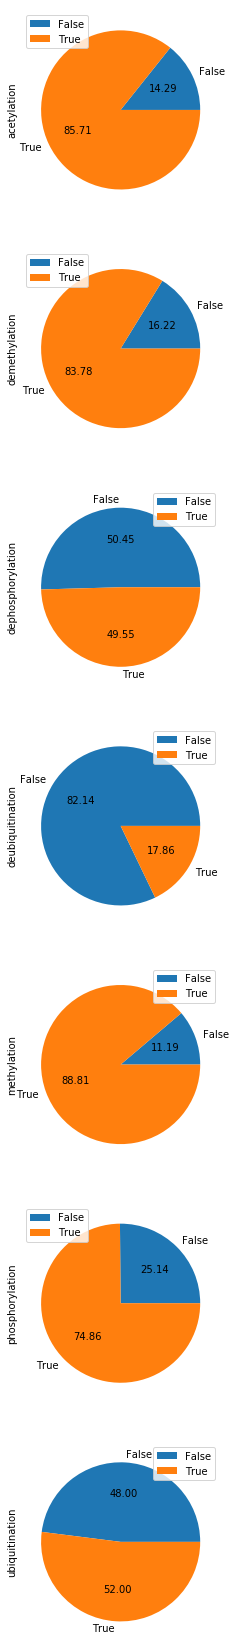

In [320]:
fig, ax = plt.subplots( 7,1, figsize=(45,30))
data.groupby(['hasTriggerWord', 'interactionType']).size().unstack().plot(kind='pie', subplots='True',autopct='%.2f', ax=ax)
plt.show()

### Explore how many of the entity alias are mentioned in the abstract

In [321]:
def getEntityMentionsCount(r):
    count = 0
    for p in r["participants"]:
        if p is None or p['alias'] is None : continue
    
        count += len([a for a in p['alias'] if a[0] in r["pubmedabstract"]])
        
    return count
        

data["entityMentionsCount"] = data.apply(lambda r: getEntityMentionsCount(r)  , 1)

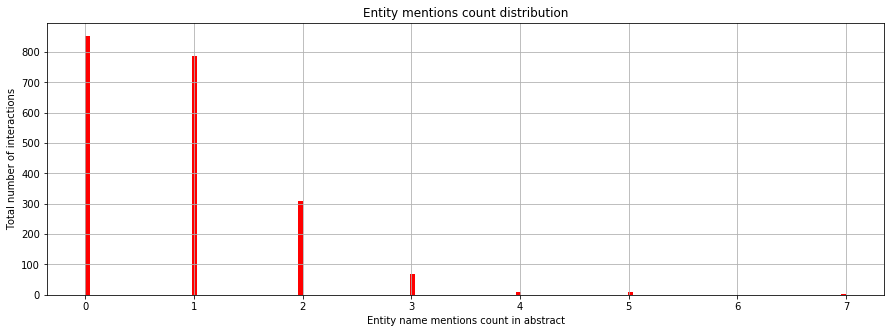

In [336]:
data['entityMentionsCount'].hist ( bins=150, figsize=(15,5), color = 'red')
plt.title('Entity mentions count distribution')
plt.xlabel('Entity name mentions count in abstract')
plt.ylabel('Total number of interactions')

plt.show()